In [1]:
import os
import PIL
from skimage import io

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, CenterCrop, Compose, ToTensor

from mmd import MMDWAE
from model import Encoder, Decoder

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [4]:
def sample_latent_prior(batch_size, device):
    return torch.normal(torch.zeros(batch_size, z_dim), torch.ones(batch_size, z_dim)).to(device)

def cost(Y_true, Y_pred):
    return torch.nn.functional.mse_loss(Y_pred, Y_true)

def kernel(z1, z2):

    z11 = z1.unsqueeze(1).repeat(1, z2.size(0), 1)
    z22 = z2.unsqueeze(0).repeat(z1.size(0), 1, 1)
    
    C = 1

    kernel_matrix = C/(1e-9+C+(z11-z22).pow(2).sum(2))
    kernel_sum = kernel_matrix.sum()

    return kernel_sum

In [10]:
class CelebaDataset(Dataset):
    def __init__(self, mode='train', transforms=None):
        self.mode = mode        
        
        self.root_dir = '/root/data/sdc/wae-wgan/_datasets/CelebA/splits/'
        self.img_dir = os.path.join(self.root_dir, self.mode)
        self.img_ids = os.listdir(self.img_dir)
        
        self.transforms = transforms
    
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img = PIL.Image.fromarray(io.imread(os.path.join(self.img_dir, img_id)))  
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, img

In [11]:
def get_train_valid_loader(batch_size=100, random_seed=42, shuffle=False):
    transforms = Compose([CenterCrop((140, 140)),
                          Resize((64, 64)),
                          ToTensor()])
    
    train_dataset = CelebaDataset(mode="train", transforms=transforms)
    valid_dataset = CelebaDataset(mode="valid", transforms=transforms)
    
    train_sampler = None
    if shuffle:
        indices = np.arange(len(train_dataset))
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        train_sampler = SubsetRandomSampler(indices)
        
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,  sampler=train_sampler)
    
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    
    return train_loader, valid_loader

In [16]:
train_loader, valid_loader = get_train_valid_loader()

device = torch.device("cuda:"+str(0) if torch.cuda.is_available() else "cpu")
batch_size = 128
nc = 3
z_dim = 64
lr = 1e-4

encoder = Encoder(nc, z_dim, 4)
decoder = Decoder(nc, z_dim, 8)

optimizer = torch.optim.Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=lr)

mmd = MMDWAE(cost=cost, decoder=decoder, encoder=encoder, device=device, lamda_coeff=0.1, kernel=kernel,
       sample_latent_prior=sample_latent_prior, trainloader=train_loader, optimizer=optimizer)

In [18]:
mmd.train(50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

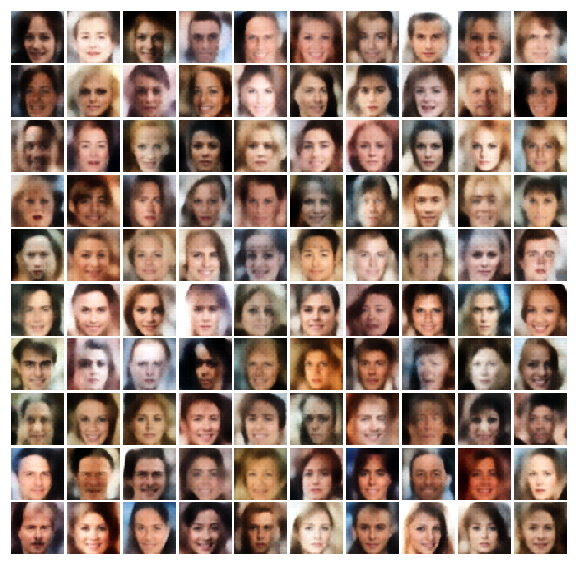

In [25]:
sample = mmd.sample(100)

plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for j in range(100):
    ax1 = plt.subplot(gs1[j])
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.imshow(np.transpose(sample.data.cpu().numpy()[j], (1, 2, 0)))

In [ ]:
mmd.train(50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

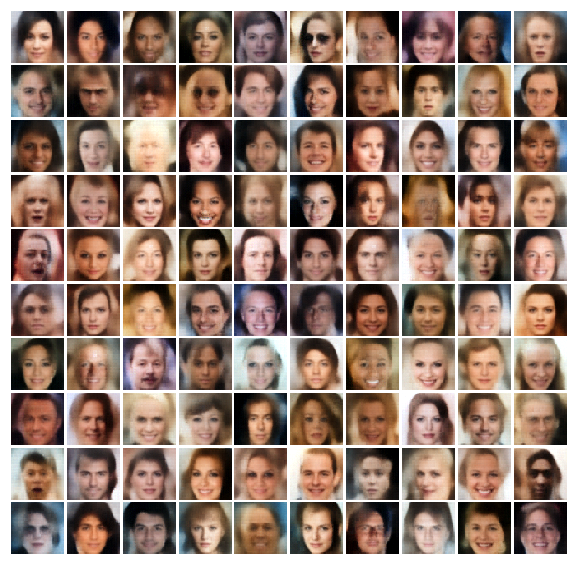

In [20]:
sample = mmd.sample(100)

plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(100):
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.imshow(np.transpose(sample.data.cpu().numpy()[i], (1, 2, 0)))